We need:

- A function that for given $A$ and $y_0$ computes iid solutions $Y_1$ of the SDE $$\mathrm{d} Y^k = A^k_{i\gamma}Y^i \circ \mathrm{d}W^\gamma + B^k_iY^i \mathrm{d}t, \qquad Y_0 = y_0, $$ and averages them.
- A function that computes the same mean directly as the solution to an ODE by converting to Itô and taking expectations $$\mathbb E Y_1^k = \int \bigg(\frac 12 \sum_{\gamma = 1}^d A^k_{i \gamma} A^i_{j \gamma} \mathbb E Y_t^j + B^k_i \mathbb E Y^i \bigg)\mathrm{d} t $$
- A function that takes the cubature points and weights and computes the weak error, as the absolute difference of the above mean and the Euler solution of the cubature of degrees 3, 5, 7 on $m$ intervals.

In [5]:
import importlib
import jax
jax.config.update("jax_enable_x64", True)
from diffrax import *
import jax.random as jr
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt
import utils_plots as ut
import pickle
import random

importlib.reload(ut)

<module 'utils_plots' from '/Users/emilioferrucci/Documents/MATH/PostDoc Oxford/cubature/utils_plots.py'>

In [2]:
e, d = 2, 3
sample_size = 100
key = jax.random.PRNGKey(92712)
key0AB = jax.random.split(key, 3)

y0 = jax.random.normal(key0AB[0], (e,))
y0 = y0 / jnp.linalg.norm(y0)
A = jax.random.normal(key0AB[1], (e, e, d))
A = A / jnp.linalg.norm(A)
B = jax.random.normal(key0AB[2], (e, e))
B = B / jnp.linalg.norm(B)

# uncomment if you want zero drift
#B = jnp.zeros((e,e))

#ut.mean_ODE(y0, A, B) - ut.monte_carlo(sample_size, d, y0, A, B)

# mean_ODE works well, use that from now on
true_mean = ut.mean_ODE(y0, A, B)

One step cubature, return:

$$\Big[y_0 + \sum_{n = 1}^\mathrm{degree} C^{\otimes n} y_0 \pi_n \exp(\mathcal L_i) : i = 1,...,\mathrm{nopts} \Big]$$

where $C = (B | A)$ (drift in the zero-th coordinate).

In [ ]:
# this just creates a list of jnp arrays of ones of the right dimension to check that the function above works
def one_cub_sim(degree, no_pts, d):
    return [jnp.ones((no_pts,) + (1 + d,) * (k)) for k in range(degree + 1)]

cub_size = 648
deg = 7
cub_sim = one_cub_sim(deg, cub_size, d)
w = jnp.ones(cub_size) / cub_size
ut.multistep_cubature(y0, A, B, cub_sim, w, 3)
#this only takes 18 seconds on my laptop, but presumably only because of the fact that 
# the points and weights are ones + some jax magic 

#cub_size_3 = 5 # made up sizes just to plot quickly
#cub_size_5 = 10
#cub_size_7 = 15

#cub_sim_3, cub_sim_5, cub_sim_7 = one_cub_sim(3, cub_size_3, d), one_cub_sim(5, cub_size_5, d), one_cub_sim(7, cub_size_7, d)
#w3, w5, w7 = jnp.ones(cub_size_3) / cub_size_3, jnp.ones(cub_size_5) / cub_size_5, jnp.ones(cub_size_7) / cub_size_7


In [11]:
with open("degree_3.pkl", "rb") as f:
    cubature_3 = pickle.load(f)
    
with open("degree_5.pkl", "rb") as f:
    cubature_5 = pickle.load(f)

with open("degree_7.pkl", "rb") as f:
    cubature_7 = pickle.load(f)
    
points_3, weights_3 = cubature_3[0][:4], cubature_3[1]
points_5, weights_5 = cubature_5[0][:6], cubature_5[1]
points_7, weights_7 = cubature_7[0], cubature_7[1]


In [12]:
c3 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_3, weights_3, m) - true_mean)
c5 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_5, weights_5, m) - true_mean)
c7 = lambda m: jnp.linalg.norm(ut.multistep_cubature(y0, A, B, points_7, weights_7, m) - true_mean)

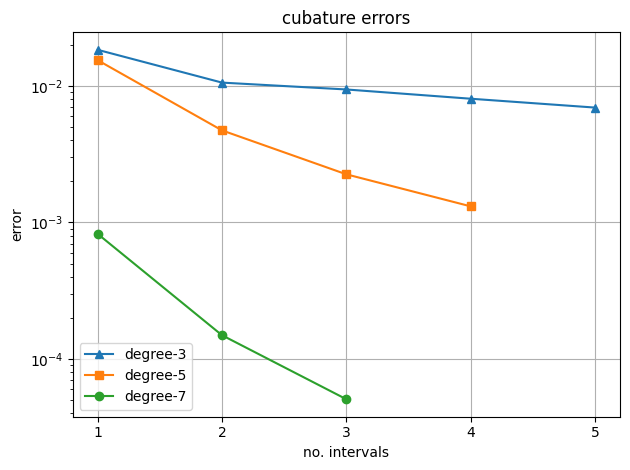

In [13]:
ut.plot_functions([c3, c5, c7], [5, 4, 3], labels=["degree-3", "degree-5", "degree-7"], title="cubature errors",
                   xlabel="no. intervals", ylabel="error", scale="log") # also the ms would be changed from one formula to the next

TODO next:

- input cubature formulae for $d = 3$ and $N = 3, 5, 7$
- plot average over a few $A, B$'s instead of single choice
- compare speed of convergence with speed of convergence of MC (change solver)

Code that comes later is still to be sorted

In [ ]:
mc_100 = lambda grid_size: jnp.linalg.norm(ut.monte_carlo(100, d, y0, A, B, grid_size) - true_mean)
mc_1k = lambda grid_size: jnp.linalg.norm(ut.monte_carlo(1000, d, y0, A, B, grid_size) - true_mean)
mc_10k = lambda grid_size: jnp.linalg.norm(ut.monte_carlo(10000, d, y0, A, B, grid_size) - true_mean)

importlib.reload(ut)
mc_1k(int(1e3))

Array(0.02126601, dtype=float64)

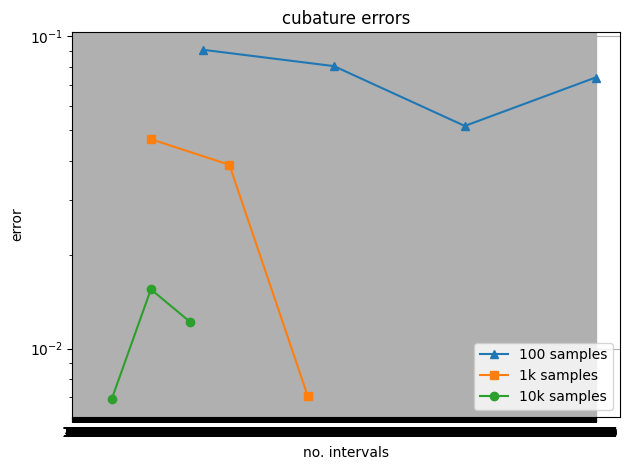

In [14]:
ut.plot_functions([mc_100, mc_1k, mc_10k], [20000, 10000, 5000], labels=["100 samples", "1k samples", "10k samples"], title="cubature errors",
                   xlabel="no. intervals", ylabel="error", scale="log", step = [5000, 3000, 1500])

In [ ]:

def average_cubature_error(no_eqs, m, degree, e, key=None):
    """
    Computes the average normed error from multistep_cubature over 'no_eqs' random systems.

    Args:
        no_eqs: number of equations A,B to average over
        m: number of intervals
        degree: 3, 5, or 7 (cubature degree)
        e: solution dimension
        d = 3
        key: optional PRNGKey. If None, one is created randomly.

    Returns:
        Scalar: average error
    """
    if key is None:
        seed = random.randint(0, 2**32 - 1)
        key = jax.random.PRNGKey(seed)

    if degree == 3:
        pts, wts = points_3, weights_3
    elif degree == 5:
        pts, wts = points_5, weights_5
    elif degree == 7:
        pts, wts = points_7, weights_7
    else:
        raise ValueError("degree must be 3, 5, or 7")

    keys = jax.random.split(key, no_eqs * 3).reshape(no_eqs, 3, 2)

    def single_error(k_triple):
        key_y0, key_A, key_B = k_triple

        y0 = jax.random.normal(key_y0, (e,))
        y0 /= jnp.linalg.norm(y0)

        A = jax.random.normal(key_A, (e, e, 3))
        A /= jnp.linalg.norm(A)

        B = jax.random.normal(key_B, (e, e))
        B /= jnp.linalg.norm(B)

        approx = ut.multistep_cubature(y0, A, B, pts, wts, m)
        return jnp.linalg.norm(approx - true_mean)

    errors = jax.vmap(single_error)(keys)
    return jnp.mean(errors)

import jax
import jax.numpy as jnp
import random

def average_cubature_error_for(no_eqs, m, degree, e, d, key=None): #this one uses a for loop instead of vmap
    """
    Computes the average normed error from multistep_cubature over 'no_eqs' random systems.

    Args:
        no_eqs: number of equations
        m: number of intervals
        degree: 3, 5, or 7 (cubature degree)
        e: system dimension
        d: stochastic dimension (dim A[:,:,i])
        key: optional PRNGKey. If None, one is created randomly.

    Returns:
        Scalar: average error
    """
    if key is None:
        seed = random.randint(0, 2**32 - 1)
        key = jax.random.PRNGKey(seed)

    if degree == 3:
        pts, wts = points_3, weights_3
    elif degree == 5:
        pts, wts = points_5, weights_5
    elif degree == 7:
        pts, wts = points_7, weights_7
    else:
        raise ValueError("degree must be 3, 5, or 7")

    keys = jax.random.split(key, no_eqs * 3).reshape(no_eqs, 3, 2)

    errors = []
    for i in range(no_eqs):
        key_y0, key_A, key_B = keys[i]

        y0 = jax.random.normal(key_y0, (e,))
        y0 /= jnp.linalg.norm(y0)

        A = jax.random.normal(key_A, (e, e, d))
        A /= jnp.linalg.norm(A)

        B = jax.random.normal(key_B, (e, e))
        B /= jnp.linalg.norm(B)

        approx = multistep_cubature(y0, A, B, pts, wts, m)
        err = jnp.linalg.norm(approx - true_mean)
        errors.append(err)

    return jnp.mean(jnp.array(errors))


In [16]:
# With a fixed key (for reproducibility)
key = jax.random.PRNGKey(0)
avg = average_cubature_error(no_eqs = 1, m = 3, degree = 7, e = 2)

# Or with a fresh random seed
# avg = average_cubature_error(no_eqs = 2, m = 3, degree = 7, e = 2, key=key)
